# WMA Charting Notebook

#### Packages and Tools

In [1]:
from utils.packages import *
from utils.tools import *
%matplotlib inline

#### Read from config file

In [2]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)
    
temp_file = 'config/wma.yaml'
with open(temp_file) as temp_file:
    wma = yaml.load(temp_file)    

In [3]:
slope_num = 20

In [4]:
instrument = wma['curr']['instrument']    
pip = wma['pip_size'][instrument]

short_moving_window = wma['wma']['short_moving_window']
long_moving_window = wma['wma']['long_moving_window']
lists_size = wma['wma']['lists_size']

access_token = config['oanda_demo_account']['token']
accountID = config['oanda_demo_account']['account_id']

In [5]:
def get_slopes(short_wma_list, long_wma_list, num):
    short_slope_y = list(short_wma_list)[-num:]
    short_slope_x = list(np.arange(1,len(short_slope_y)+1))
    short_slope_x_plt = list(np.arange(lists_size - slope_num + 1, lists_size+1))
    #short_slope, short_intercept = np.polyfit(short_slope_x, short_slope_y, 1)
    short_slope, short_intercept, _, _, _ = linregress(short_slope_x, short_slope_y)
    abline_short = [short_slope * i + short_intercept for i in short_slope_x]
    
    long_slope_y = list(long_wma_list)[-num:]
    long_slope_x = list(np.arange(1,len(long_slope_y)+1))
    long_slope_x_plt = list(np.arange(lists_size - slope_num + 1, lists_size+1))
    #long_slope, long_intercept = np.polyfit(long_slope_x, long_slope_y, 1)
    long_slope, long_intercept, _, _, _ = linregress(long_slope_x, long_slope_y)    
    abline_long = [long_slope * i + long_intercept for i in long_slope_x]
    
    numerator = short_slope - long_slope
    denominator = 1 + (short_slope * long_slope)
    angle = math.degrees(math.atan(abs(numerator / denominator)))
    angle = round(angle, 2)

    return(short_slope_x_plt, long_slope_x_plt, abline_short, abline_long, angle)

#### Code Engine

In [6]:
seconds_elapsed, sec_per_iter, iter_counts, heart_beats, iter_per, heart_per = get_hit_speed(access_token, 
                                                                                             accountID, 
                                                                                             instrument, 
                                                                                             iter_limit = 2)

1it [00:03,  3.74s/it]

seconds_elapsed:4.0
sec_per_iter:4.0
iter_counts:2 --- iter_per:1.0
heart_beats:0 --- heart_per:0.0


KeyboardInterrupt: 

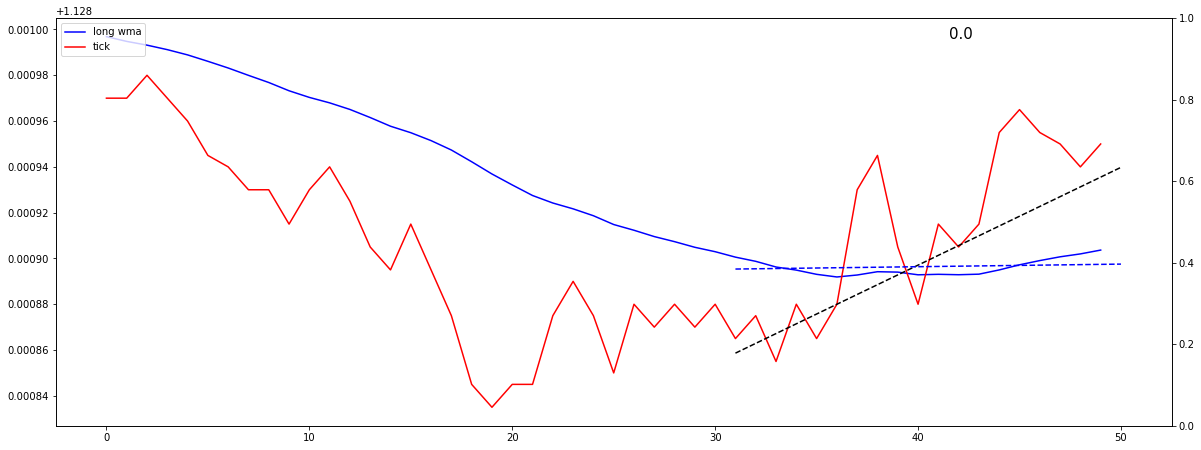

In [7]:
api = API(access_token = access_token)
params = {'instruments': instrument}
order_flag = 'not_ordered'
r = pricing.PricingStream(accountID=accountID, params=params)
rv = api.request(r)

short_wma = 0
short_flag = True
short_list = collections.deque([])
short_wma_list = collections.deque([])
short_weights = get_weights(short_moving_window)

stan_dev = 0
stan_dev_list = collections.deque([])

long_wma = 0
long_flag = True
long_list = collections.deque([])
long_wma_list = collections.deque([])
long_weights = get_weights(long_moving_window)

tick_list = collections.deque([])

start_time = time.time()
time_flag = True 
long_list_counter = 0

list_ready = False

for i, resp in enumerate(rv):        
    resp_type = resp['type']       

    # Heart beat response to keep the api connection alive (Avoid timeout)
    if resp_type == 'HEARTBEAT': 
        pass
    #-----------------------------------------------------------------------------------------------------
    
    
    # Price response 
    elif resp_type == 'PRICE': # Check if we are yet to make the order               
        
        #Decode values from response
        date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
        sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response 
        #-----------------------------------------------------------------------------------------
        
        #Prepare short list to calculate WMA of shortwindows
        if len(short_list) < short_moving_window:
            short_list.append(tick_price)

        # Calculate wma for first iteration
        if short_flag and len(short_list) == short_moving_window:
            short_wma = sum(np.array(short_list)*short_weights)
            short_flag =  False

        # Calculate wma from the second iteration
        if short_flag == False and len(short_list) == short_moving_window:
            short_list.popleft()   
            short_list.append(tick_price) 
            short_wma = sum(np.array(short_list)*short_weights)
            stan_dev = statistics.stdev(short_list)
            stan_dev = stan_dev * 10**5

        # Append WMA list
        if len(short_list) == short_moving_window:
            if len(short_wma_list) < lists_size:
                short_wma_list.append(short_wma)
                #stan_dev_list.append(stan_dev)

            elif len(short_wma_list) == lists_size:
                short_wma_list.popleft()   
                short_wma_list.append(short_wma) 
                
                #stan_dev_list.popleft() 
                #stan_dev_list.append(stan_dev)
                
        #print(f'short_wma_list : {len(short_wma_list)}')
        #-----------------------------------------------------------------------------------------
        
        
        #Prepare long list to calculate WMA of longwindows
        if len(long_list) < long_moving_window:
            long_list.append(tick_price)
            
         # Calculate wma for first iteration
        if long_flag and len(long_list) == long_moving_window:
            long_wma = sum(np.array(long_list)*long_weights)
            long_flag =  False

        # Calculate wma from the second iteration
        if long_flag == False and len(long_list) == long_moving_window:
            long_list.popleft()   
            long_list.append(tick_price) 
            long_wma = sum(np.array(long_list)*long_weights)

        # Append WMA list
        if len(long_list) == long_moving_window:
            if len(long_wma_list) < lists_size:
                long_wma_list.append(long_wma)
                tick_list.append(tick_price)

            # If WMA list reached required size start plotting
            elif len(long_wma_list) == lists_size:
                if time_flag:
                    end_time = time.time()    
                    duration = calc_duration(start_time, end_time)
                    time_flag = False
                    
                    df_wma = pd.DataFrame()
                    df_wma['seconds_elapsed'] = [seconds_elapsed]
                    df_wma['sec_per_iter'] = [sec_per_iter]
                    df_wma['iter_counts'] = [iter_counts]
                    df_wma['heart_beats'] = [heart_beats]
                    df_wma['iter_per'] = [iter_per]
                    df_wma['heart_per'] = [heart_per]
                    df_wma['short_moving_window'] = [short_moving_window]
                    df_wma['long_moving_window'] = [long_moving_window]
                    df_wma['lists_size'] = [lists_size]
                    df_wma['chart_duration'] = [duration]
                    df_wma.to_csv('data/machine_use/wma_chart.csv', mode='a', header=False, index = False)
                    winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)           

                plt.close()
                long_wma_list.popleft()   
                long_wma_list.append(long_wma)  
                
                tick_list.popleft()   
                tick_list.append(tick_price)
                
                short_slope_x_plt, long_slope_x_plt, abline_short, abline_long, angle = get_slopes(short_wma_list, long_wma_list, slope_num)
                
                fig, ax1 = plt.subplots(1,1, figsize=(20,7.5))
                ax2 = ax1.twinx()

                ax1.plot(long_wma_list,'b' ,label="long wma")
                ax1.plot(tick_list, 'r' ,label="tick")
                ax1.plot(short_slope_x_plt, abline_short, 'k--')
                ax1.plot(long_slope_x_plt, abline_long, 'b--')
                ax1.text(0.80, 0.95, angle, transform=plt.gca().transAxes, fontsize=15)

                #ax2.plot(stan_dev_list,'y--' ,label="std dev")

                ax1.legend(loc="upper left")
                #ax2.legend(loc="upper right")

                display.display(plt.gcf())
                display.clear_output(wait = True)                

In [ ]:
short_slope_x, long_slope_x, abline_short, abline_long, angle = get_slopes(short_wma_list, long_wma_list, slope_num)

In [ ]:
numerator = short_slope - long_slope
denominator = 1 + (short_slope * long_slope)
angle = math.degrees(math.atan(abs(numerator / denominator)))

In [ ]:
df_copy = pd.read_csv('data/machine_use/wma_chart.csv')
df_copy.to_csv('data/wma_chart.csv', index = False)                        

In [ ]:
num = 20

In [ ]:
math.degrees(0.5)

In [ ]:
denominator

In [30]:
#x1 = [2,2,2,2,2,2,2,2,2]
x1 = [1,2,3,4,5,6,7,8,9]
y1 = [1,2,3,4,5,6,7,8,9]

x2 = [1,2,3,4,5,6,7,8,9]
y2 = [2,2,2,2,2,2,2,2,2]

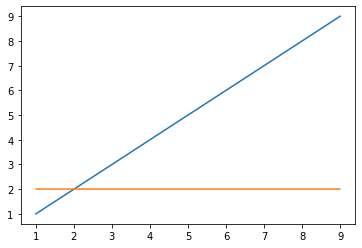

In [31]:
plt.plot(x1,y1)
plt.plot(x2,y2)

In [32]:
numerator

1.0

In [33]:
denominator

1.0

In [34]:
from scipy.stats import linregress

In [36]:
slope1, intercept1, _, _, _ = linregress(x1, y1)

In [37]:
slope2, intercept2, _, _, _ = linregress(x2, y2)

In [38]:
print(slope1, slope2)

1.0 0.0


In [39]:
numerator =  slope2 - slope1

In [40]:
numerator

-1.0

In [42]:
denominator = 1 + (slope1 * slope2)
angle = math.degrees(math.atan(abs(numerator / denominator)))

In [43]:
angle

45.0

In [ ]:
math.degrees(math.atan(abs(numerator / denominator)))

In [ ]:
numerator = slope1 - slope2
denominator = 1 + (slope1 * slope2)
angle_1 = math.atan(abs(numerator / denominator))
angle_2 = math.degrees(angle_1)
angle_3 = round(angle_2, 4)
angle_3

In [ ]:
slope1, intercept1 = np.polyfit(x1, y1, 1)
print(slope1, intercept1)

In [ ]:
slope2, intercept2 = np.polyfit(x2, y2, 1)
print(slope2, intercept2)

In [ ]:
x = math.tan(10)
print(x)

x2 = math.atan(x)
print(x2)

In [ ]:
x = np.tan(10)
print(x)

x2 = np.arctan(x)
print(x2)

In [ ]:
x

In [ ]:
math.cos(x)/math.sin(x)

In [ ]:
numerator = long_slope - short_slope
denominator = 1 + (short_slope * long_slope)
angle_1 = math.atan(abs(numerator / denominator))
#angle_1 = math.atan(abs(3 / 11))
angle_2 = math.degrees(angle_1)
angle_3 = round(angle_2, 4)
angle_3

In [9]:
num = 20

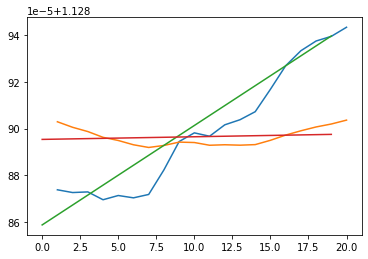

In [23]:
plt.plot(short_slope_x, short_slope_y)
plt.plot(long_slope_x, long_slope_y)
plt.plot(abline_short)
plt.plot(abline_long)

In [68]:
s_slope_x = [1.00001, 1.00002, 1.00003, 1.00004, 1.00005,
            1.00006, 1.00007, 1.00008, 1.00009, 1.00010,
            1.00011, 1.00012, 1.00013, 1.00014, 1.00015,
            1.00016, 1.00017, 1.00018, 1.00019, 1.00020,]

In [83]:
l1 = []
for i in range(20):
    l1.append(1 + ((i+1)*pip*0.1))
print(l1)

[1.00001, 1.00002, 1.00003, 1.00004, 1.00005, 1.00006, 1.00007, 1.00008, 1.00009, 1.0001, 1.00011, 1.00012, 1.00013, 1.00014, 1.00015, 1.00016, 1.00017, 1.00018, 1.00019, 1.0002]


In [69]:
np.array(short_slope_y)

array([1.12887373, 1.12887255, 1.12887282, 1.12886945, 1.12887127,
       1.12887027, 1.12887173, 1.12888227, 1.12889445, 1.12889818,
       1.12889673, 1.12890164, 1.12890382, 1.12890727, 1.12891691,
       1.128927  , 1.12893345, 1.12893764, 1.12893964, 1.12894355])

In [70]:
np.std(short_slope_y)

2.5552900888193474e-05

In [71]:
short_slope, short_intercept, _, _, _ = linregress(s_slope_x, short_slope_y)
print(short_slope, short_intercept)

0.42712235133299914 0.7017320190019292


In [46]:
short_slope, short_intercept, _, _, _ = linregress(short_slope_x, short_slope_y)
print(short_slope, short_intercept)

217502.13651844813 -245527.49186855118


In [72]:
long_slope, long_intercept, _, _, _ = linregress(s_slope_x, long_slope_y)
print(long_slope, long_intercept)

0.011348665782351348 1.1175465926077415


# Final Angle here

In [73]:
numerator = short_slope - long_slope
denominator = 1 + (short_slope * long_slope)
angle_1 = math.degrees(math.atan(abs(numerator / denominator)))
angle_2 = round(angle_1, 2)
angle_2

22.48

In [45]:
long_slope, long_intercept, _, _, _ = linregress(long_slope_x, long_slope_y)
print(long_slope, long_intercept)

1.1348665782356144e-07 1.1288952583900929


In [11]:
short_slope_y = list(short_wma_list)[-num:]
short_slope_x = list(np.arange(1,len(short_slope_y)+1))
short_slope_x_plt = list(np.arange(lists_size - slope_num + 1, lists_size+1))
#short_slope, short_intercept = np.polyfit(short_slope_x, short_slope_y, 1)
short_slope, short_intercept, _, _, _ = linregress(short_slope_x, short_slope_y)
abline_short = [short_slope * i + short_intercept for i in short_slope_x]

long_slope_y = list(long_wma_list)[-num:]
long_slope_x = list(np.arange(1,len(long_slope_y)+1))
long_slope_x_plt = list(np.arange(lists_size - slope_num + 1, lists_size+1))
#long_slope, long_intercept = np.polyfit(long_slope_x, long_slope_y, 1)
long_slope, long_intercept, _, _, _ = linregress(long_slope_x, long_slope_y)    
abline_long = [long_slope * i + long_intercept for i in long_slope_x]

numerator = short_slope - long_slope
denominator = 1 + (short_slope * long_slope)
angle_1 = math.degrees(math.atan(abs(numerator / denominator)))
angle_2 = round(angle_1, 2)
angle_1

0.00023822077414500307

In [ ]:
abline_long

In [ ]:
long_slope

In [ ]:
short_slope_x_plt

In [ ]:
'''
df = pd.DataFrame({'tick_list':tick_list, 
                   'short_wma_list':short_wma_list, 
                   'stan_dev_list':stan_dev_list,
                   'long_wma_list':long_wma_list},
                  columns = ['tick_list', 'short_wma_list', 'long_wma_list','stan_dev_list'])

df.head()
'''

In [ ]:
'''
from IPython.display import clear_output
import time

for i in range(10):
    clear_output(wait=True)
    time.sleep(1)
    print(i)    
'''